In [1]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend
from psiam_tied_dv_map_utils_for_noise import psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_V_A_change_added_noise_fn, up_RTs_fit_OPTIM_V_A_change_added_noise_fn, down_RTs_fit_OPTIM_V_A_change_added_noise_fn, PA_with_LEDON_2
from psiam_tied_dv_map_utils_with_PDFs import up_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn, down_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn
import pandas as pd
import random
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.integrate import trapezoid as trapz
from pyvbmc import VBMC
import corner
from diagnostics_class import Diagnostics
from scipy.integrate import cumulative_trapezoid as cumtrapz

In [2]:
import os
def psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change_M3_delGO(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, \
                                t_stim_and_led_tuple, new_V_A, new_noise, T0_factor, iter_num, N_print, is_LED_trial, del_go, dt):
    ABL = random.choice(ABL_arr)
    ILD = random.choice(ILD_arr)
    
    # random element from t_stim_and_led_tuple
    t_stim, t_led = t_stim_and_led_tuple

    # print after every N_print iterations
    if iter_num % N_print == 0:
        print(f'os id: {os.getpid()}, In iter_num: {iter_num}, ABL: {ABL}, ILD: {ILD}, t_stim: {t_stim}')

    choice, rt, is_act = simulate_psiam_tied_noise_change_no_L_T0_factor_M3_delGO(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, is_LED_trial, t_led, new_V_A, new_noise, T0_factor, del_go, dt)
    return {'choice': choice, 'rt': rt, 'is_act': is_act ,'ABL': ABL, 'ILD': ILD, 't_stim': t_stim, 't_led': t_led, 'is_LED_trial': is_LED_trial}

def simulate_psiam_tied_noise_change_no_L_T0_factor_M3_delGO(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, is_LED_trial, t_led, new_V_A, new_noise, T0_factor, del_go, dt):
    AI = 0; DV = Z_E; t = t_A_aff; dB = dt**0.5
    
    chi = 17.37; q_e = 1
    theta = theta_E * q_e

    mu = (2*q_e/T_0) * (10**(rate_lambda * ABL/20)) * np.sinh(rate_lambda * ILD/chi)
    sigma = np.sqrt( (2*(q_e**2)/T_0) * (10**(rate_lambda * ABL/20)) * np.cosh(rate_lambda * ILD/ chi) )

    # firing rates decrease
    new_T0 = T_0 * T0_factor
    # mu changes with firing rate
    new_mu = (2*q_e/new_T0) * (10**(rate_lambda * ABL/20)) * np.sinh(rate_lambda * ILD/chi)
    # sigma changes with firing rate
    new_sigma = np.sqrt( (2*(q_e**2)/new_T0) * (10**(rate_lambda * ABL/20)) * np.cosh(rate_lambda * ILD/ chi) )
    new_sigma = np.sqrt(new_sigma**2 + new_noise**2)

    is_act = 0
    while True:
        if t >= t_led and is_LED_trial:
            mu = new_mu
            sigma = new_sigma
            V_A = new_V_A
        
        AI += V_A*dt + np.random.normal(0, dB)

        if t > t_stim + t_E_aff:
            DV += mu*dt + sigma*np.random.normal(0, dB)
        
        
        t += dt
        
        if DV >= theta:
            choice = +1; RT = t
            break
        elif DV <= -theta:
            choice = -1; RT = t
            break
        
        if AI >= theta_A:
            is_act = 1
            AI_hit_time = t
            did_EA_hit = 0
            # if t*dt > t_stim - t_motor:
            while t <= (AI_hit_time + del_go):#  u can process evidence till stim plays
                if t > t_stim + t_E_aff: # Evid accum wil begin only after stim starts and afferent delay
                    if t >= t_led and is_LED_trial:
                        mu = new_mu
                        sigma = new_sigma
                        V_A = new_V_A

                    DV += mu*dt + sigma*np.random.normal(0, dB)
                    if DV >= theta:
                        DV = theta
                        did_EA_hit = 1
                        break
                    elif DV <= -theta:
                        DV = -theta
                        did_EA_hit = -1
                        break
                t += dt
            
            break
        
        
    if is_act == 1:
        RT = AI_hit_time
        if did_EA_hit == 0:
            randomly_choose_up = np.random.rand() >= 0.5
            if randomly_choose_up:
                choice = 1
            else:
                choice = -1
        else:
            choice = did_EA_hit
               
    
    return choice, RT, is_act



In [3]:
V_A = 1.6
theta_A = 2.53
V_A_post_LED = V_A + 1.8
t_A_aff = -0.187
t_E_aff = 0.075
Z_E = 0
K_max = 10

rate_lambda = 0.118
theta_E = 45
T_0 = 2.9 * 1e-3
del_go = 0.12
noise = 69.54

In [4]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()

In [5]:
# sim
N_sim = int(500e3)
N_print = int(N_sim/5)
is_LED_trial = True
dt = 1e-4

sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_sim)
t_stim_and_led_tuple_samples = [t_stim_and_led_tuple[i] for i in sampled_indices]

sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change_M3_delGO)(V_A, theta_A, ABL_arr, ILD_arr,\
                                                                                        rate_lambda, T_0, theta_E, Z_E, \
                                                                                            t_A_aff, t_E_aff,\
                                                                                    t_stim_and_led_tuple_samples[iter_num], \
                                                                        V_A_post_LED, noise, 1, iter_num, N_print, is_LED_trial, del_go, dt) \
                                                                              for iter_num in tqdm(range(N_sim)))


  0%|          | 0/500000 [00:00<?, ?it/s]

os id: 420265, In iter_num: 0, ABL: 20, ILD: 4.0, t_stim: 0.437213151594988
os id: 420260, In iter_num: 100000, ABL: 60, ILD: -16.0, t_stim: 0.532229879256455
os id: 420270, In iter_num: 200000, ABL: 40, ILD: -8.0, t_stim: 0.493603957302108
os id: 420304, In iter_num: 300000, ABL: 40, ILD: 16.0, t_stim: 0.224164054111588
os id: 420263, In iter_num: 400000, ABL: 60, ILD: -1.0, t_stim: 0.345755746794678


# RTDs sim wise

In [6]:
def theory_RTD(bin_size, ABL, ILD, t_LED, t_stim):
    t_pts = np.arange(-1,1, bin_size)
    pdf = [all_RTs_fit_OPTIM_V_A_change_added_noise_fn(t + t_stim, t_LED, V_A, V_A_post_LED, theta_A, ABL, ILD, rate_lambda, T_0, noise, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, K_max) \
           for t in t_pts]
    return pdf

In [7]:
N_theory = int(1e3)
bin_size = 0.05

sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_sim)
t_stim_and_led_tuple_samples = [t_stim_and_led_tuple[i] for i in sampled_indices]
ABL_samples = np.ones((N_theory,))*ABL_arr[0]
ILD_samples = np.ones((N_theory,))*ILD_arr[0]


theory_results = Parallel(n_jobs=30)(delayed(theory_RTD)(bin_size, ABL_samples[iter], ILD_samples[iter], t_stim_and_led_tuple_samples[iter][1], t_stim_and_led_tuple_samples[iter][0]) for iter in tqdm(range(N_theory)))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
sim_results_df = pd.DataFrame(sim_results)

In [9]:
sim_results_df_1 = sim_results_df[(sim_results_df['ABL'] == ABL_arr[0]) & (sim_results_df['ILD']==ILD_arr[0])]
sim_rt = sim_results_df_1['rt'] - sim_results_df_1['t_stim']

In [10]:
# add a column called correct in sim_results_df correct = 1 if ILD * choice > 0 else 0
sim_results_df['correct'] = (sim_results_df['ILD'] * sim_results_df['choice'] > 0).astype(int)

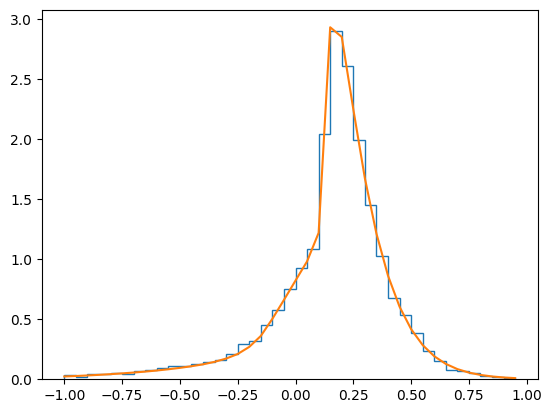

In [11]:
theory_results_np = np.array(theory_results)
theory_results_np_mean = np.mean(theory_results_np, axis=0)

t_pts = np.arange(-1,1, bin_size)

plt.hist(sim_rt, bins=t_pts, density=True, histtype='step')
plt.plot(t_pts, theory_results_np_mean)

# psychometric

In [12]:
import numpy as np
from scipy.special import erf
import math
import numpy as np


def d_A_RT_VEC(a, t):
    """
    Calculate the standard PA probability density function (vectorized).

    Parameters:
        a (float): Scalar parameter.
        t (numpy.ndarray): Time values (must be > 0).

    Returns:
        numpy.ndarray: The computed pdf values (0 where t <= 0).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    p = np.zeros_like(t)
    valid_indices = t > 0
    p[valid_indices] = (1.0 / np.sqrt(2 * np.pi * (t[valid_indices]**3))) * np.exp(-((1 - a * t[valid_indices])**2) / (2 * t[valid_indices]))
    return p

def stupid_f_integral_VEC(v, vON, theta, t, tp):
    """
    Calculate the PA pdf after the v_A change via an integral expression (vectorized).

    Parameters:
        v (float): Scalar parameter.
        vON (float): Scalar parameter.
        theta (float): Scalar parameter.
        t (numpy.ndarray): Time values.
        tp (numpy.ndarray): A shifted time values.

    Returns:
        numpy.ndarray: The evaluated integral expressions.
    """
    t = np.asarray(t)
    tp = np.asarray(tp)
    a1 = 0.5 * (1 / t + 1 / tp)
    b1 = theta / t + (v - vON)
    c1 = -0.5 * (vON**2 * t - 2 * theta * vON + theta**2 / t + v**2 * tp)

    a2 = a1
    b2 = theta * (1 / t + 2 / tp) + (v - vON)
    c2 = -0.5 * (vON**2 * t - 2 * theta * vON + theta**2 / t + v**2 * tp + 4 * theta * v + 4 * theta**2 / tp) + 2 * v * theta

    F01 = 1.0 / (4 * np.pi * a1 * np.sqrt(tp * t**3))
    F02 = 1.0 / (4 * np.pi * a2 * np.sqrt(tp * t**3))

    T11 = b1**2 / (4 * a1)
    T12 = (2 * a1 * theta - b1) / (2 * np.sqrt(a1))
    T13 = theta * (b1 - theta * a1)

    T21 = b2**2 / (4 * a2)
    T22 = (2 * a2 * theta - b2) / (2 * np.sqrt(a2))
    T23 = theta * (b2 - theta * a2)

    I1 = F01 * (T12 * np.sqrt(np.pi) * np.exp(T11 + c1) * (erf(T12) + 1) + np.exp(T13 + c1))
    I2 = F02 * (T22 * np.sqrt(np.pi) * np.exp(T21 + c2) * (erf(T22) + 1) + np.exp(T23 + c2))

    STF = I1 - I2
    return STF

def PA_with_LEDON_2_VEC(t, v, vON, a, tfix, tled, delta_A):
    """
    Compute the PA pdf by combining contributions before and after LED onset (vectorized).

    Parameters:
        t (numpy.ndarray): Time values.
        v (float): Drift parameter before LED.
        vON (float): Drift parameter after LED onset.
        a (float): Decision bound.
        tfix (float): Fixation time.
        tled (float): LED time.
        delta_A (float): Delta parameter.

    Returns:
        numpy.ndarray: The combined PA pdf values.
    """
    t = np.asarray(t)
    result = np.zeros_like(t)
    before_led = (t + tfix) <= (tled + 1e-6)
    result[before_led] = d_A_RT_VEC(v * a, (t[before_led] - delta_A + tfix) / (a**2)) / (a**2)
    result[~before_led] = stupid_f_integral_VEC(v, vON, a, t[~before_led] + tfix - tled, tled - delta_A + tfix)
    return result

In [13]:
from psiam_tied_dv_map_utils_with_PDFs import phi, M
def CDF_E_minus_small_t_NORM_added_noise_VEC_fn(t_pts, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, noise, K_max):
    """
    In normalized time, CDF of hitting the lower bound.
    Processes a vector of time points t_pts (as a NumPy array) and returns a vector
    where each element is a likelihood.
    """
    # Ensure t_pts is a numpy array
    t_pts = np.asarray(t_pts)
    
    # For negative or zero time points, the likelihood is defined as 0.
    results = np.zeros_like(t_pts, dtype=float)
    positive_mask = t_pts > 0
    if not np.any(positive_mask):
        return results  # All t_pts are <= 0
    
    # Work only on t values > 0
    t = t_pts[positive_mask]
    
    # Constant parameters
    chi = 17.37
    omega = (2/T_0) * (10**(rate_lambda*ABL/20))
    sigma_sq = omega
    q_e = 1
    theta = theta_E * q_e
    
    arg = rate_lambda * ILD / chi
    v = (theta * omega * np.sinh(arg)) / ((omega * np.cosh(arg)) + (noise**2))
    
    # Compute w and adjust if bound==1
    w = (Z_E + theta) / (2*theta)
    a = 2
    if bound == 1:
        v = -v
        w = 1 - w
    
    # Adjust time scaling factor
    t_theta = (theta**2) / (sigma_sq + noise**2)
    t = t / t_theta  # Now t is scaled and remains a vector.
    
    # Compute the exponent part for each t
    exponent_arg = -v * a * w - ((v**2) * t) / 2
    result = np.exp(exponent_arg)  # This is a vector (same shape as t)
    
    # Prepare vectorized computation over k values.
    k_vals = np.arange(K_max + 1)
    # Compute r_k for each k; vectorized over k
    r_k = np.where(k_vals % 2 == 0, k_vals * a + a * w, k_vals * a + a * (1 - w))
    # Reshape r_k to enable broadcasting: shape (K_max+1, 1)
    r_k = r_k[:, None]
    
    # Precompute sqrt(t) with shape (1, n)
    sqrt_t = np.sqrt(t)[None, :]
    
    # Compute term1 = phi(r_k / sqrt(t))
    term1 = phi(r_k / sqrt_t)
    
    # Compute term2 = M((r_k - v*t)/sqrt(t)) + M((r_k + v*t)/sqrt(t))
    # Here, note that v*t is broadcast properly since v is a scalar and t is (1, n)
    term2 = (M((r_k - v * t) / sqrt_t) + M((r_k + v * t) / sqrt_t))
    
    # Multiply by (-1)**k. Reshape (-1)**k to (K_max+1, 1) for broadcasting.
    signs = ((-1) ** k_vals)[:, None]
    
    # Sum over k axis (axis=0) to get a vector of length n (matching t)
    summation = np.sum(signs * term1 * term2, axis=0)
    
    # Combine the exponent part with the summation term
    likelihood = result * summation
    
    # Place likelihood values back into the output array, zeros for t_pts <= 0.
    results[positive_mask] = likelihood
    return results


In [14]:
def rho_E_minus_small_t_NORM_added_noise_VEC_fn(t_pts, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, noise, K_max):
    """
    In normalized time, added noise to variance of firing rates to PDF of hitting the lower bound.
    Processes a vector of time points (t_pts) and returns an array where each element is a likelihood.
    """
    import numpy as np

    # Ensure t_pts is a numpy array
    t_pts = np.asarray(t_pts, dtype=float)
    results = np.zeros_like(t_pts, dtype=float)
    
    # For t values <= 0, we define the density as 0.
    positive_mask = t_pts > 0
    if not np.any(positive_mask):
        return results  # all t_pts are <= 0
    
    # Process only t > 0
    t = t_pts[positive_mask]
    
    # Constant parameters
    chi = 17.37
    omega = (2 / T_0) * (10**(rate_lambda * ABL / 20))
    sigma_sq = omega
    q_e = 1
    theta = theta_E * q_e

    # Compute evidence v
    arg = rate_lambda * ILD / chi
    v = (theta * omega * np.sinh(arg)) / ((omega * np.cosh(arg)) + (noise**2))
    
    # Compute w and adjust if bound==1
    w = (Z_E + theta) / (2 * theta)
    a = 2
    if bound == 1:
        v = -v
        w = 1 - w

    # Scale time by t_theta
    t_theta = (theta**2) / (sigma_sq + noise**2)
    t_scaled = t / t_theta

    # Compute the non-summation term (vectorized in t)
    non_sum_term = (1 / a**2) * (a**3 / np.sqrt(2 * np.pi * t_scaled**3)) * np.exp(-v * a * w - (v**2 * t_scaled) / 2)

    # Prepare k values, using only odd number of terms symmetric around zero.
    K_max_half = int(K_max / 2)
    k_vals = np.linspace(-K_max_half, K_max_half, 2 * K_max_half + 1)
    # Reshape k_vals to allow broadcasting: shape (n_k, 1)
    k_vals = k_vals[:, None]
    
    # Compute the term (w + 2*k) for each k value.
    sum_w_term = w + 2 * k_vals  # shape (n_k, 1)
    
    # For the exponential term, we need to broadcast over t_scaled.
    # Expand t_scaled to shape (1, n) so that division works elementwise.
    t_scaled_exp = t_scaled[None, :]
    sum_exp_term = np.exp(-(a**2 * (w + 2 * k_vals)**2) / (2 * t_scaled_exp))
    
    # Sum over k values (axis=0) to get a vector of length equal to t_scaled.
    sum_result = np.sum(sum_w_term * sum_exp_term, axis=0)
    
    # Compute density (vectorized)
    density = non_sum_term * sum_result
    # Avoid negative densities by thresholding them at 1e-16.
    density = np.where(density <= 0, 1e-16, density)
    
    # Place the computed densities back in the result vector, rescaling by t_theta.
    results[positive_mask] = density / t_theta
    return results


In [15]:
from psiam_tied_dv_map_utils_with_PDFs import CDF_E_minus_small_t_NORM_added_noise_fn, rho_E_minus_small_t_NORM_added_noise_fn


def up_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_NO_PA_part_VEC_fn(t_pts, P_A, C_A, ABL, ILD, rate_lambda, T_0, noise, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max):
    """
    PDF of all RTs array irrespective of choice
    """
    bound = 1
    t2 = t_pts - t_stim - t_E_aff + del_go
    t1 = t_pts - t_stim - t_E_aff

    prob_EA_hits_either_bound = CDF_E_minus_small_t_NORM_added_noise_VEC_fn(t_pts - t_stim - t_E_aff + del_go, ABL, ILD,\
                                                                         rate_lambda, T_0, theta_E, Z_E, 1, noise, K_max) \
                             + CDF_E_minus_small_t_NORM_added_noise_VEC_fn(t_pts - t_stim - t_E_aff + del_go, ABL, ILD,\
                                                                         rate_lambda, T_0, theta_E, Z_E, -1, noise, K_max)
    
    prob_EA_survives = 1 - prob_EA_hits_either_bound
    random_readout_if_EA_surives = 0.5 * prob_EA_survives
    P_E_plus_cum = CDF_E_minus_small_t_NORM_added_noise_VEC_fn(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, noise, K_max) \
                    - CDF_E_minus_small_t_NORM_added_noise_VEC_fn(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, noise, K_max)
    
    

    P_E_plus = rho_E_minus_small_t_NORM_added_noise_VEC_fn(t_pts-t_E_aff-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, noise, K_max)
    

    P_up = (P_A*(random_readout_if_EA_surives + P_E_plus_cum) + P_E_plus*(1-C_A))

    return P_up


In [16]:

t_pts = np.arange(0, 5, 0.05)

N_theory = int(1e3)
sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_theory)
t_stim_and_led_tuple_samples = [t_stim_and_led_tuple[i] for i in sampled_indices]

P_A_t_led_vs_t = np.zeros((N_theory, len(t_pts)))
C_A_t_led_vc_t = np.zeros((N_theory, len(t_pts)))

for pair_idx, pair in tqdm(enumerate(t_stim_and_led_tuple_samples), total=len(t_stim_and_led_tuple_samples)):
    t_LED = pair[1]
    P_A_t_led_vs_t[pair_idx, :] = PA_with_LEDON_2_VEC(t_pts, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff)

    C_A_vec = cumtrapz(P_A_t_led_vs_t[pair_idx, :], t_pts, initial=0)
    C_A_t_led_vc_t[pair_idx, :] = C_A_vec

#### SERIAL #####
# p_up_per_ABL = np.zeros((len(ABL_arr), len(ILD_arr)))
# for ABL_i, ABL in enumerate(ABL_arr):
#     print(f'ABL: {ABL}')
#     p_up_ILD = np.zeros_like(ILD_arr)
#     for ILD_i, ILD in enumerate(ILD_arr):
#         print(f'ILD: {ILD}')
#         P_up_samples = np.zeros((N_theory, len(t_pts)))
#         for pair_idx, pair in enumerate(t_stim_and_led_tuple_samples):
#             P_A = P_A_t_led_vs_t[pair_idx, :]
#             C_A = C_A_t_led_vc_t[pair_idx, :]
#             t_stim = pair[0]    
#             P_up_samples[pair_idx, :] = up_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_NO_PA_part_VEC_fn(t_pts, P_A, C_A, ABL, ILD,\
#                                                                     rate_lambda, T_0, noise, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max)
        
#         P_up_samples_mean = np.mean(P_up_samples, axis=0)
#         p_up_ILD[ILD_i] = trapz(P_up_samples_mean, t_pts)

    
#     p_up_per_ABL[ABL_i] = p_up_ILD

  0%|          | 0/1000 [00:00<?, ?it/s]

# Parallel psychometric

In [17]:
# Parallel ###########
from joblib import Parallel, delayed

def process_ABL_ILD(ABL_idx, ABL, ILD_idx, ILD, t_stim_and_led_tuple_samples, P_A_t_led_vs_t, C_A_t_led_vc_t, 
                    t_pts, rate_lambda, T_0, noise, theta_E, Z_E, t_A_aff, t_E_aff, del_go, K_max, N_theory):
    """Process a single ABL/ILD combination and return the results with indices."""
    P_up_samples = np.zeros((N_theory, len(t_pts)))
    
    for pair_idx, pair in enumerate(t_stim_and_led_tuple_samples):
        P_A = P_A_t_led_vs_t[pair_idx, :]
        C_A = C_A_t_led_vc_t[pair_idx, :]
        t_stim = pair[0]    
        P_up_samples[pair_idx, :] = up_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_NO_PA_part_VEC_fn(
            t_pts, P_A, C_A, ABL, ILD, rate_lambda, T_0, noise, theta_E, Z_E, 
            t_stim, t_A_aff, t_E_aff, del_go, K_max
        )
    
    P_up_samples_mean = np.mean(P_up_samples, axis=0)
    p_up = trapz(P_up_samples_mean, t_pts)
    
    return (ABL_idx, ILD_idx, p_up)

# Create the output matrix
p_up_per_ABL = np.zeros((len(ABL_arr), len(ILD_arr)))

# Generate all combinations of ABL and ILD indices and values
combinations = [
    (ABL_idx, ABL, ILD_idx, ILD) 
    for ABL_idx, ABL in enumerate(ABL_arr)
    for ILD_idx, ILD in enumerate(ILD_arr)
]

# Run the calculations in parallel
results = Parallel(n_jobs=30, verbose=10)(
    delayed(process_ABL_ILD)(
        ABL_idx, ABL, ILD_idx, ILD, 
        t_stim_and_led_tuple_samples, P_A_t_led_vs_t, C_A_t_led_vc_t,
        t_pts, rate_lambda, T_0, noise, theta_E, Z_E, 
        t_A_aff, t_E_aff, del_go, K_max, N_theory
    )
    for ABL_idx, ABL, ILD_idx, ILD in combinations
)

# Fill the output matrix with the results
for ABL_idx, ILD_idx, p_up in results:
    p_up_per_ABL[ABL_idx, ILD_idx] = p_up

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   3 out of  30 | elapsed:    0.4s remaining:    3.6s
[Parallel(n_jobs=30)]: Done   7 out of  30 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=30)]: Done  11 out of  30 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=30)]: Done  19 out of  30 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  23 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  27 out of  30 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished


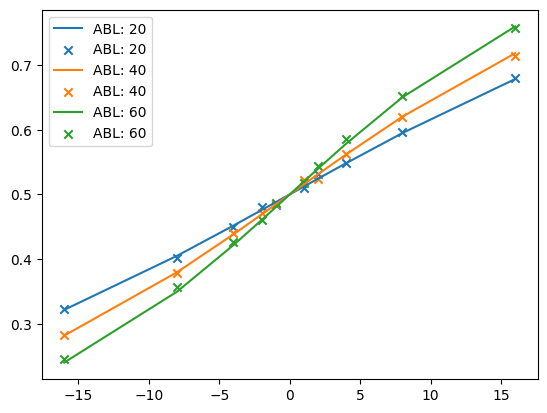

In [18]:
for ABL_i, ABL in enumerate(ABL_arr):
    sim_p_up = np.zeros_like(ILD_arr)
    for ILD_i, ILD in enumerate(ILD_arr):
        sim_ABL_ILD_df = sim_results_df[ (sim_results_df['ABL'] == ABL) & (sim_results_df['ILD'] == ILD) ]
        # convert choice -1 to 0
        sim_ABL_ILD_df.loc[:,'choice'] = (sim_ABL_ILD_df['choice'] + 1)/2
        # mean of choice
        sim_p_up[ILD_i] = np.mean(sim_ABL_ILD_df['choice'])
    plt.plot(ILD_arr, p_up_per_ABL[ABL_i], label=f'ABL: {ABL}')
    plt.scatter(ILD_arr, sim_p_up, label=f'ABL: {ABL}', marker='x')
plt.legend()
plt.show()

# psychometric efficient

In [19]:
t_pts = np.arange(-5, 5, 0.001)

N_theory = int(1e3)
sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_theory)
t_stim_and_led_tuple_samples = [t_stim_and_led_tuple[i] for i in sampled_indices]

P_A_t_led_vs_t = np.zeros((N_theory, len(t_pts)))

for pair_idx, pair in tqdm(enumerate(t_stim_and_led_tuple_samples), total=len(t_stim_and_led_tuple_samples)):
    t_LED = pair[1]
    t_stim = pair[0]
    P_A_t_led_vs_t[pair_idx, :] = PA_with_LEDON_2_VEC(t_pts, V_A, V_A_post_LED, theta_A, t_stim, t_LED, t_A_aff)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
# P_A mean and C_A 
P_A_t_mean = np.mean(P_A_t_led_vs_t, axis=0)
C_A_t_mean = cumtrapz(P_A_t_mean, t_pts, initial=0)

In [21]:
def up_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_NO_PA_part_VEC_NO_stimfn(t_pts, P_A, C_A, ABL, ILD, rate_lambda, T_0, noise, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max):
    """
    PDF of all RTs array irrespective of choice
    """
    bound = 1
    t_stim = 0

    t2 = t_pts - t_stim - t_E_aff + del_go
    t1 = t_pts - t_stim - t_E_aff
    
    prob_EA_hits_either_bound = CDF_E_minus_small_t_NORM_added_noise_VEC_fn(t_pts - t_stim - t_E_aff + del_go, ABL, ILD,\
                                                                         rate_lambda, T_0, theta_E, Z_E, 1, noise, K_max) \
                             + CDF_E_minus_small_t_NORM_added_noise_VEC_fn(t_pts - t_stim - t_E_aff + del_go, ABL, ILD,\
                                                                         rate_lambda, T_0, theta_E, Z_E, -1, noise, K_max)
    
    prob_EA_survives = 1 - prob_EA_hits_either_bound
    random_readout_if_EA_surives = 0.5 * prob_EA_survives
    P_E_plus_cum = CDF_E_minus_small_t_NORM_added_noise_VEC_fn(t2, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, noise, K_max) \
                    - CDF_E_minus_small_t_NORM_added_noise_VEC_fn(t1, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, noise, K_max)
    
    

    P_E_plus = rho_E_minus_small_t_NORM_added_noise_VEC_fn(t_pts-t_E_aff-t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, bound, noise, K_max)
    

    P_up = (P_A*(random_readout_if_EA_surives + P_E_plus_cum) + P_E_plus*(1-C_A))

    return P_up


In [22]:
t_pts_wrt_stim = np.arange(-5, 5, 0.001)
p_up_dict = {}
for ABL in ABL_arr:
    p_up_vs_ILD = np.zeros_like(ILD_arr)
    for ILD_i, ILD in enumerate(ILD_arr):
        p_up_abl_ild_vs_t = up_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_NO_PA_part_VEC_NO_stimfn(t_pts, P_A_t_mean, C_A_t_mean, \
                                                                                    ABL, ILD, rate_lambda, T_0, noise, theta_E, Z_E,\
                                                                                          0, t_A_aff, t_E_aff, del_go, K_max)
        p_up_vs_ILD[ILD_i] = trapz(p_up_abl_ild_vs_t, t_pts)
    p_up_dict[ABL] = p_up_vs_ILD

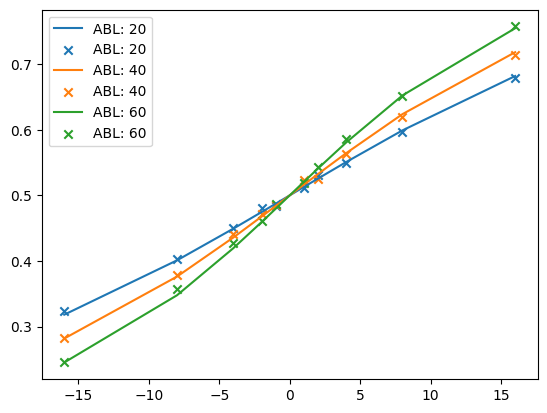

In [23]:
for ABL_i, ABL in enumerate(ABL_arr):
    sim_p_up = np.zeros_like(ILD_arr)
    for ILD_i, ILD in enumerate(ILD_arr):
        sim_ABL_ILD_df = sim_results_df[ (sim_results_df['ABL'] == ABL) & (sim_results_df['ILD'] == ILD) ]
        # convert choice -1 to 0
        sim_ABL_ILD_df.loc[:,'choice'] = (sim_ABL_ILD_df['choice'] + 1)/2
        # mean of choice
        sim_p_up[ILD_i] = np.mean(sim_ABL_ILD_df['choice'])
    plt.plot(ILD_arr, p_up_dict[ABL], label=f'ABL: {ABL}')
    plt.scatter(ILD_arr, sim_p_up, label=f'ABL: {ABL}', marker='x')
plt.legend()
plt.show()

# check P_A and C_A t_LED

In [24]:
def proactive_with_LED_sim(t_LED):
    dt = 1e-4; dB = 1e-2
    dv = 0; t = t_A_aff
    while True:
        if t < t_LED:
            v = V_A
        else:
            v = V_A_post_LED
        
        t += dt
        dv += v*dt + np.random.normal(0, dB)
        
        if dv >= theta_A:
            return t

In [25]:
N_sim_check = int(50e3)
# sample 50k indices len(t_stim_and_led_tuple)
sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_sim_check)
t_led = [t_stim_and_led_tuple[i][1] for i in sampled_indices]

proactive_rts = Parallel(n_jobs=30)(delayed(proactive_with_LED_sim)(t) for t in tqdm(t_led))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [26]:
N_theory = int(5e3)
t_led_sampled_idx = np.random.choice(t_led, N_theory)
bins_theory = np.arange(0.001, 3, 0.005)

P_A_vs_t_LED = np.zeros((N_theory, len(bins_theory)))
for idx, t_LED in enumerate(t_led_sampled_idx):
    P_A_vs_t_LED[idx] = PA_with_LEDON_2_VEC(bins_theory, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff)


P_A_vs_t_LED_mean = np.mean(P_A_vs_t_LED, axis=0)

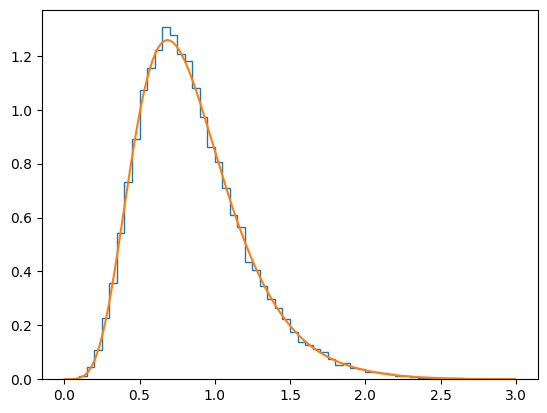

In [27]:
bins = np.arange(0,3,0.05)
plt.hist(proactive_rts, bins=bins, density=True, histtype='step');
plt.plot(bins_theory, P_A_vs_t_LED_mean)


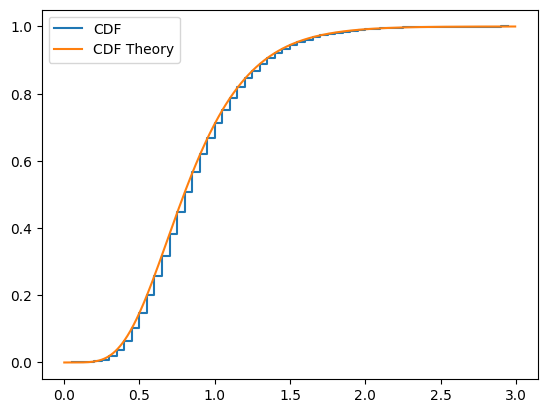

In [28]:
cdf_theory = cumtrapz(P_A_vs_t_LED_mean, bins_theory, initial=0)
counts, bin_edges = np.histogram(proactive_rts, bins=bins, density=True)
cdf = np.cumsum(counts * np.diff(bin_edges))  # Normalize to get a CDF

# Plot the CDF
plt.plot(bin_edges[1:], cdf, drawstyle='steps-post', label="CDF")
plt.plot(bins_theory, cdf_theory, label="CDF Theory")
plt.legend()

# quantile

In [29]:
# theory
def all_CDF_addeed_noise_VEC_fn(t_pts, P_A, C_A, ABL, ILD, rate_lambda, T_0, noise, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max):
    """
    PDF of all RTs array irrespective of choice
    """
    C_E = CDF_E_minus_small_t_NORM_added_noise_VEC_fn(t_pts - t_E_aff, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, 1, noise, K_max) \
                    + CDF_E_minus_small_t_NORM_added_noise_VEC_fn(t_pts - t_E_aff, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, -1, noise, K_max)
    
    
    return C_A + C_E - ( C_A * C_E )


In [30]:
bin_size = 0.005
t_pts = np.linspace(-10, 10, int((5 - (-5)) / bin_size) + 1)  # Ensure it includes 0


N_theory = int(1e3)
sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_theory)
t_stim_and_led_tuple_samples = [t_stim_and_led_tuple[i] for i in sampled_indices]

P_A_t_led_vs_t = np.zeros((N_theory, len(t_pts)))

for pair_idx, pair in tqdm(enumerate(t_stim_and_led_tuple_samples), total=len(t_stim_and_led_tuple_samples)):
    t_LED = pair[1]
    t_stim = pair[0]
    P_A_t_led_vs_t[pair_idx, :] = PA_with_LEDON_2_VEC(t_pts, V_A, V_A_post_LED, theta_A, t_stim, t_LED, t_A_aff)

P_A_mean = np.mean(P_A_t_led_vs_t, axis=0)
C_A = cumtrapz(P_A_mean, t_pts, initial=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:

# frac of proactive responses
trapz(P_A_mean, t_pts), C_A[-1], len(sim_results_df[sim_results_df['is_act'] == 1])/len(sim_results_df)

(0.768829484589173, 0.7688294845891721, 0.59783)

In [32]:
# frac of aborts
N_aborts = len(sim_results_df[sim_results_df['rt'] < sim_results_df['t_stim']])
frac_aborts = N_aborts/len(sim_results_df) 
print(f'frac_aborts: {frac_aborts}')

frac_aborts: 0.19227


CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318
CDF_0: 0.2380695134211318


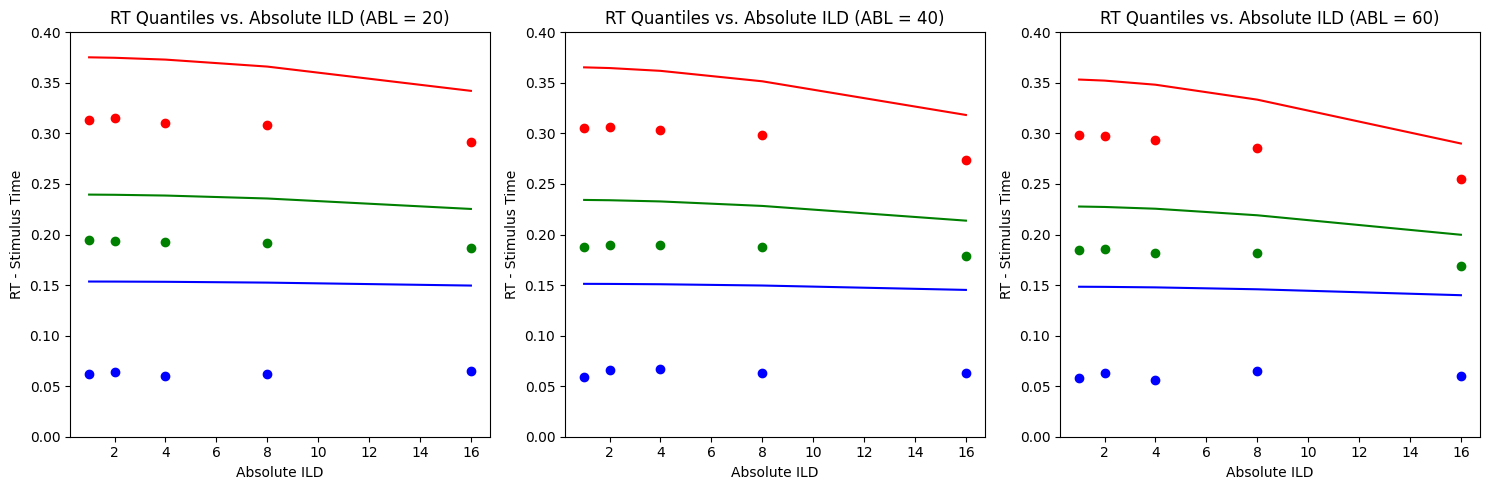

In [33]:
def find_quantile(cdf_values, time_points, quantile):
    return np.interp(quantile, cdf_values, time_points)


t_pts_zero_idx = np.where(t_pts == 0.0)[0][0]
positive_t_pts = t_pts[t_pts_zero_idx:]
C_A_pos = C_A[t_pts_zero_idx:]
C_A_0 = np.interp(0.0, t_pts, C_A) 


unique_abls = np.sort(sim_results_df['ABL'].unique()) 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, abl in enumerate(unique_abls):  
    abl_data = sim_results_df[sim_results_df['ABL'] == abl].copy()
    abl_data['abs_ILD'] = abs(abl_data['ILD'])
    
    abl_data['rt_diff'] = abl_data['rt'] - abl_data['t_stim']

    sim_quantiles = abl_data.groupby('abs_ILD')['rt_diff'].quantile([0.25, 0.5, 0.75]).unstack()

    theoretical_quantiles_25 = []
    theoretical_quantiles_50 = []
    theoretical_quantiles_75 = []
    abs_ild_values = []

    for ild in sorted(np.unique(abl_data['abs_ILD'])):  # Iterate over unique abs_ILD
        CDF_0_t0_inf = all_CDF_addeed_noise_VEC_fn(
            positive_t_pts, np.nan, C_A_pos, abl, ild, 
            rate_lambda, T_0, noise, theta_E, Z_E, 0, t_A_aff, t_E_aff, del_go, K_max
        )
        CDF_0 = all_CDF_addeed_noise_VEC_fn(
            np.array([0.]), np.nan, np.array([C_A_0]), abl, ild, 
            rate_lambda, T_0, noise, theta_E, Z_E, 0, t_A_aff, t_E_aff, del_go, K_max
        )[0]
        print(f'CDF_0: {CDF_0}')
        cdf_trunc = (CDF_0_t0_inf - CDF_0) / (1 - CDF_0)

        # Compute theoretical quantiles
        quantile_25 = find_quantile(cdf_trunc, positive_t_pts, 0.25)
        quantile_50 = find_quantile(cdf_trunc, positive_t_pts, 0.50)
        quantile_75 = find_quantile(cdf_trunc, positive_t_pts, 0.75)

        # Store values
        theoretical_quantiles_25.append(quantile_25)
        theoretical_quantiles_50.append(quantile_50)
        theoretical_quantiles_75.append(quantile_75)
        abs_ild_values.append(ild)

    # Plot in the correct subplot
    ax = axes[idx]
    ax.scatter(sim_quantiles.index, sim_quantiles[0.25], label='Simulated 25th Quantile', marker='o', color='b')
    ax.scatter(sim_quantiles.index, sim_quantiles[0.5], label='Simulated 50th Quantile (Median)', marker='o', color='g')
    ax.scatter(sim_quantiles.index, sim_quantiles[0.75], label='Simulated 75th Quantile', marker='o', color='r')

    ax.plot(abs_ild_values, theoretical_quantiles_25, label='Theoretical 25th Quantile', linestyle='-', color='b')
    ax.plot(abs_ild_values, theoretical_quantiles_50, label='Theoretical 50th Quantile', linestyle='-', color='g')
    ax.plot(abs_ild_values, theoretical_quantiles_75, label='Theoretical 75th Quantile', linestyle='-', color='r')

    ax.set_xlabel('Absolute ILD')
    ax.set_ylabel('RT - Stimulus Time')
    ax.set_title(f'RT Quantiles vs. Absolute ILD (ABL = {abl})')
    ax.set_ylim(0, 0.4)


plt.tight_layout()  # Adjust layout to prevent overlapcdf_values
plt.show()


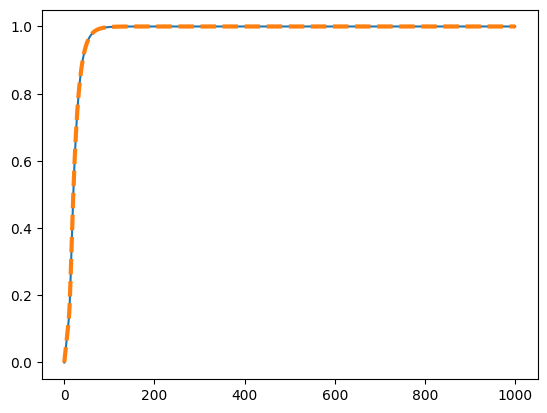

In [34]:
ild = 16
CDF_0_t0_inf = all_CDF_addeed_noise_VEC_fn(positive_t_pts, np.nan, C_A_pos, abl,  ild, rate_lambda, T_0, noise, theta_E, Z_E, 0, t_A_aff, t_E_aff, del_go, K_max)
CDF_0 = all_CDF_addeed_noise_VEC_fn(np.array([0.]), np.nan, np.array([C_A_0]), abl, ild, rate_lambda, T_0, noise, theta_E, Z_E, 0, t_A_aff, t_E_aff, del_go, K_max)[0]
cdf_trunc_4 = (CDF_0_t0_inf - CDF_0) / (1 - CDF_0)

ild = -ild
CDF_0_t0_inf = all_CDF_addeed_noise_VEC_fn(positive_t_pts, np.nan, C_A_pos, abl,  ild, rate_lambda, T_0, noise, theta_E, Z_E, 0, t_A_aff, t_E_aff, del_go, K_max)
CDF_0 = all_CDF_addeed_noise_VEC_fn(np.array([0.]), np.nan, np.array([C_A_0]), abl, ild, rate_lambda, T_0, noise, theta_E, Z_E, 0, t_A_aff, t_E_aff, del_go, K_max)[0]
cdf_trunc_minus_4 = (CDF_0_t0_inf - CDF_0) / (1 - CDF_0)

plt.plot(cdf_trunc_4)
plt.plot(cdf_trunc_minus_4, ls='--', lw=3)